In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm

In [2]:
G = 6.67e-11  
m_T = 5.9736e24  
m_L = 0.07349e24  
d = 3.844e8  
r_T = 6.3781e6  
r_L = 1.7374e6  
omega = 2.6617e-6  

In [3]:
class NaveEspacial:
    
    def __init__(self, t):
        
        self.t = t
        self.dt = t[1] - t[0]
        
        self.r_Tierra = np.array([0, 0, 0])
        self.r_Luna = np.array([d, 0, 0])
        
        self.r = np.array([r_T + 1000, 0, 0])
        self.v = np.array([0, np.sqrt(G*m_T/r_T), 0])
        
        self.R = np.zeros((len(t), 3))
        
    def GetAceleration(self, r, m):
        
        d = np.linalg.norm(r - self.r)
        return G*m*(r - self.r)/d**3
        
    def Evolution(self, i):
        
        theta = omega*self.t[i]
        self.r_Luna = np.array([d*np.cos(theta), d*np.sin(theta), 0])
        
        distancia_a_luna = np.linalg.norm(self.r - self.r_Luna)
        
        umbral_luna = r_L + 0.1  
        
        def derivs(r, v):
            a_total = self.GetAceleration(self.r_Tierra, m_T) + self.GetAceleration(self.r_Luna, m_L)
            return v, a_total

        # Runge-Kutta 4
        k1v, k1a = derivs(self.r, self.v)
        k2v, k2a = derivs(self.r + 0.5*self.dt*k1v, self.v + 0.5*self.dt*k1a)
        k3v, k3a = derivs(self.r + 0.5*self.dt*k2v, self.v + 0.5*self.dt*k2a)
        k4v, k4a = derivs(self.r + self.dt*k3v, self.v + self.dt*k3a)

        self.r += self.dt * (k1v + 2*k2v + 2*k3v + k4v) / 6
        self.v += self.dt * (k1a + 2*k2a + 2*k3a + k4a) / 6

        if distancia_a_luna <= umbral_luna:
            self.v = -self.v  # No sirve la funcion para hacer que se devuelva

        self.SetPosition(i)
    
    def SetPosition(self, i):
        self.R[i] = self.r
    
    def GetPosition(self):
        return self.R

In [4]:
dt = 1000
tmax = 3600*24*3  # Duración de 3 días
t = np.arange(0, tmax, dt)
nave = NaveEspacial(t)

In [5]:
def RunSimulation(t, nave):
    
    for i in tqdm(range(len(t)), desc='Simulando viaje a la Luna', unit='pasos'):
        nave.Evolution(i)
    
    return nave

nave = RunSimulation(t, nave)

Simulando viaje a la Luna: 100%|████████████████████████████████████████████████| 260/260 [00:00<00:00, 9973.83pasos/s]


<IPython.core.display.Javascript object>


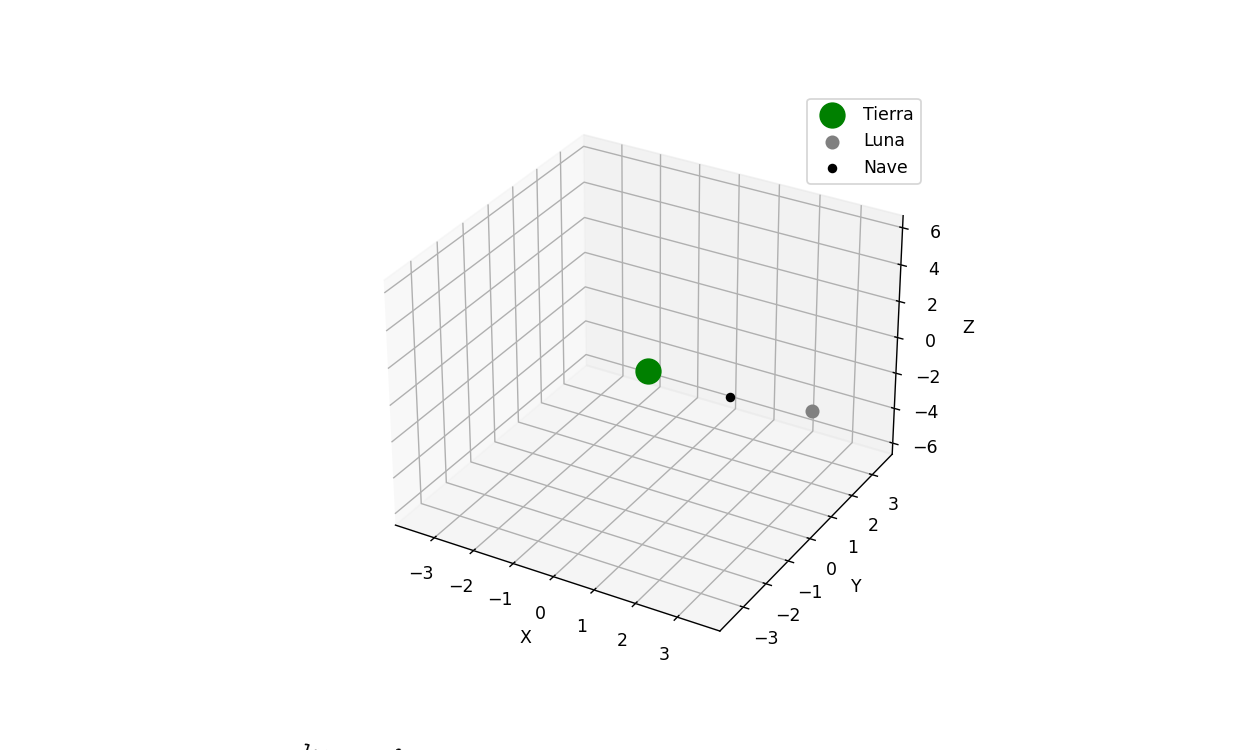

In [6]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

def init():
    ax.clear()
    ax.set_xlim([-d, d])
    ax.set_ylim([-d, d])
    ax.set_zlim([-r_T, r_T])
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

def Update(i):
    init()
    
    ax.scatter(0, 0, 0, color='green', s=200, label='Tierra')
    ax.scatter(d*np.cos(omega*t[i]), d*np.sin(omega*t[i]), 0, color='gray', s=50, label='Luna')
    x, y, z = nave.GetPosition()[i]
    ax.scatter(-x, -y, z, color='black', label='Nave')
    
    plt.legend()
    
Animation = anim.FuncAnimation(fig, Update, frames=len(t), init_func=init, interval=50)